In [73]:
import numpy as np
import matplotlib.pyplot as plt

def c_and_cprime(t, pars):
    c = pars['c0'] * np.exp(-pars['gamma'] * t)
    cp = -pars['gamma'] * pars['c0'] * np.exp(-pars['gamma'] * t)
    return c, cp

#def solve_w_eqn_RK4(w, t, h, alpha, pars):
    # First step
    #c, _ = c_and_cprime(t + 0.5 * h, pars)
    #g1 = alpha - 0.5 * w * w / c + 0.5 * -pars['gamma'] * w
    #w2 = w + 0.5 * h * g1
    # Second step
    #g2 = alpha - 0.5 * w2 * w2 / c + 0.5 * -pars['gamma'] * w2
    #w3 = w + 0.5 * h * g2
    # Third step
    #c, _ = c_and_cprime(t + 0.5 * h, pars)
    #g3 = alpha - 0.5 * w3 * w3 / c + 0.5 * -pars['gamma'] * w3
    #w4 = w + h * g3
    # Fourth step
    #c, _ = c_and_cprime(t + h, pars)
    #g4 = alpha - 0.5 * w4 * w4 / c + 0.5 * -pars['gamma'] * w4
    # RK4 final update
    #w = w + (h / 6) * (g1 + 2 * g2 + 2 * g3 + g4)
    #return w

def solve_w_eqn_RK4(w, t, h, alpha, pars):
    w = w / (1 + (w * (np.exp(pars['gamma'] * h/2) - 1) / (2 * pars['c0'] * pars['gamma']))) # Quadratic half-step
    w = (w - 2 * alpha / pars['gamma']) * np.exp(-0.5 * pars['gamma'] * h) + 2 * alpha / pars['gamma'] # Linear full-step
    w = w / (1 + (w * (np.exp(pars['gamma'] * h/2) - 1) / (2 * pars['c0'] * pars['gamma']))) # Quadratic half-step
    return w

def solve_reduced_system(w0, t0, h, alpha, pars):
    ns = pars.get('ns', 1)
    w = w0
    t = t0
    hs = h / ns
    A = 1.0
    B = 0.0
    for _ in range(ns):
        wh = solve_w_eqn_RK4(w, t, hs / 2, alpha, pars)
        w = solve_w_eqn_RK4(wh, t + 0.5 * hs, hs / 2, alpha, pars)
        ch, _ = c_and_cprime(t + 0.5 * hs, pars)
        kh = 0.5 * (-pars['gamma'] - (wh / ch))
        A = A * (1 + 0.5 * hs * kh) / (1 - 0.5 * hs * kh)
        B = (hs + B * (1 + 0.5 * hs * kh)) / (1 - 0.5 * hs * kh)
        t = t + hs
    return A, B

def kd_step(x, p, t, h, pars, Force):
    x = x + 0.5 * h * p
    F = Force(x)
    alpha = np.dot(F, F)
    w0 = np.dot(p, F)
    A, B = solve_reduced_system(w0, t, h, alpha, pars)
    p = A * p + B * F
    x = x + 0.5 * h * p
    return x, p, w0, A, B

In [57]:
def plot_diagnostics_2D(Q,P,T,W,A,B,U,potential_lambda,c_0,gamma,lim=3):
    fig, axs = plt.subplots(3, 2, figsize=(18, 12))
    x = np.linspace(-lim, lim, 100)
    y = np.linspace(-lim, lim, 100)
    X, Y = np.meshgrid(x, y)
    Z = potential_lambda(X,Y)
    contourf = axs[0][0].contourf(X, Y, Z, levels=np.linspace(0, 9, 10), cmap='viridis', alpha=0.7)
    fig.colorbar(contourf, ax=axs[0][0], label='Potential U(q)')
    _, = axs[0][0].plot(Q[:, 0], Q[:, 1], lw=1.5, color = 'yellow')
    axs[0][0].set_xlabel('q1')
    axs[0][0].set_ylabel('q2')
    axs[0][0].set_title('Trajectory on Filled Contours of Potential Function')
    axs[0][0].grid(True)
    axs[0][1].plot(T, U)
    axs[0][1].set_xlabel('t')
    axs[0][1].set_ylabel('U(q)')

    axs[1][1].plot(T, c_0 * np.exp(-gamma * T), color = 'green', label = 'Desired KE')
    axs[1][1].plot(T, 0.5 * np.linalg.norm(P, axis=1)**2, label = 'KE')
    #axs[1][1].plot(T, U, label = 'PE')
    #axs[1][1].plot(T, U + 0.5 * np.linalg.norm(P, axis=1)**2, color = 'black', label = 'Hamiltonian')
    axs[1][1].set_xlabel('t')
    axs[1][1].set_ylabel('Energy')

    axs[1][0].semilogy(T, U) 
    axs[1][0].set_xlabel('Time')
    axs[1][0].set_ylabel('log U(q)')

    axs[2][0].plot(T, A, label = 'A')
    axs[2][0].plot(T, B, label = 'B')
    axs[2][0].set_xlabel('Time')
    axs[2][0].set_title('A vs B')
    axs[2][0].legend()

    axs[2][1].plot(T, W)
    axs[2][1].set_xlabel('Time')
    axs[2][1].set_ylabel('w')
    plt.legend()
    plt.tight_layout()
    plt.show()


# Quadratic Function

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


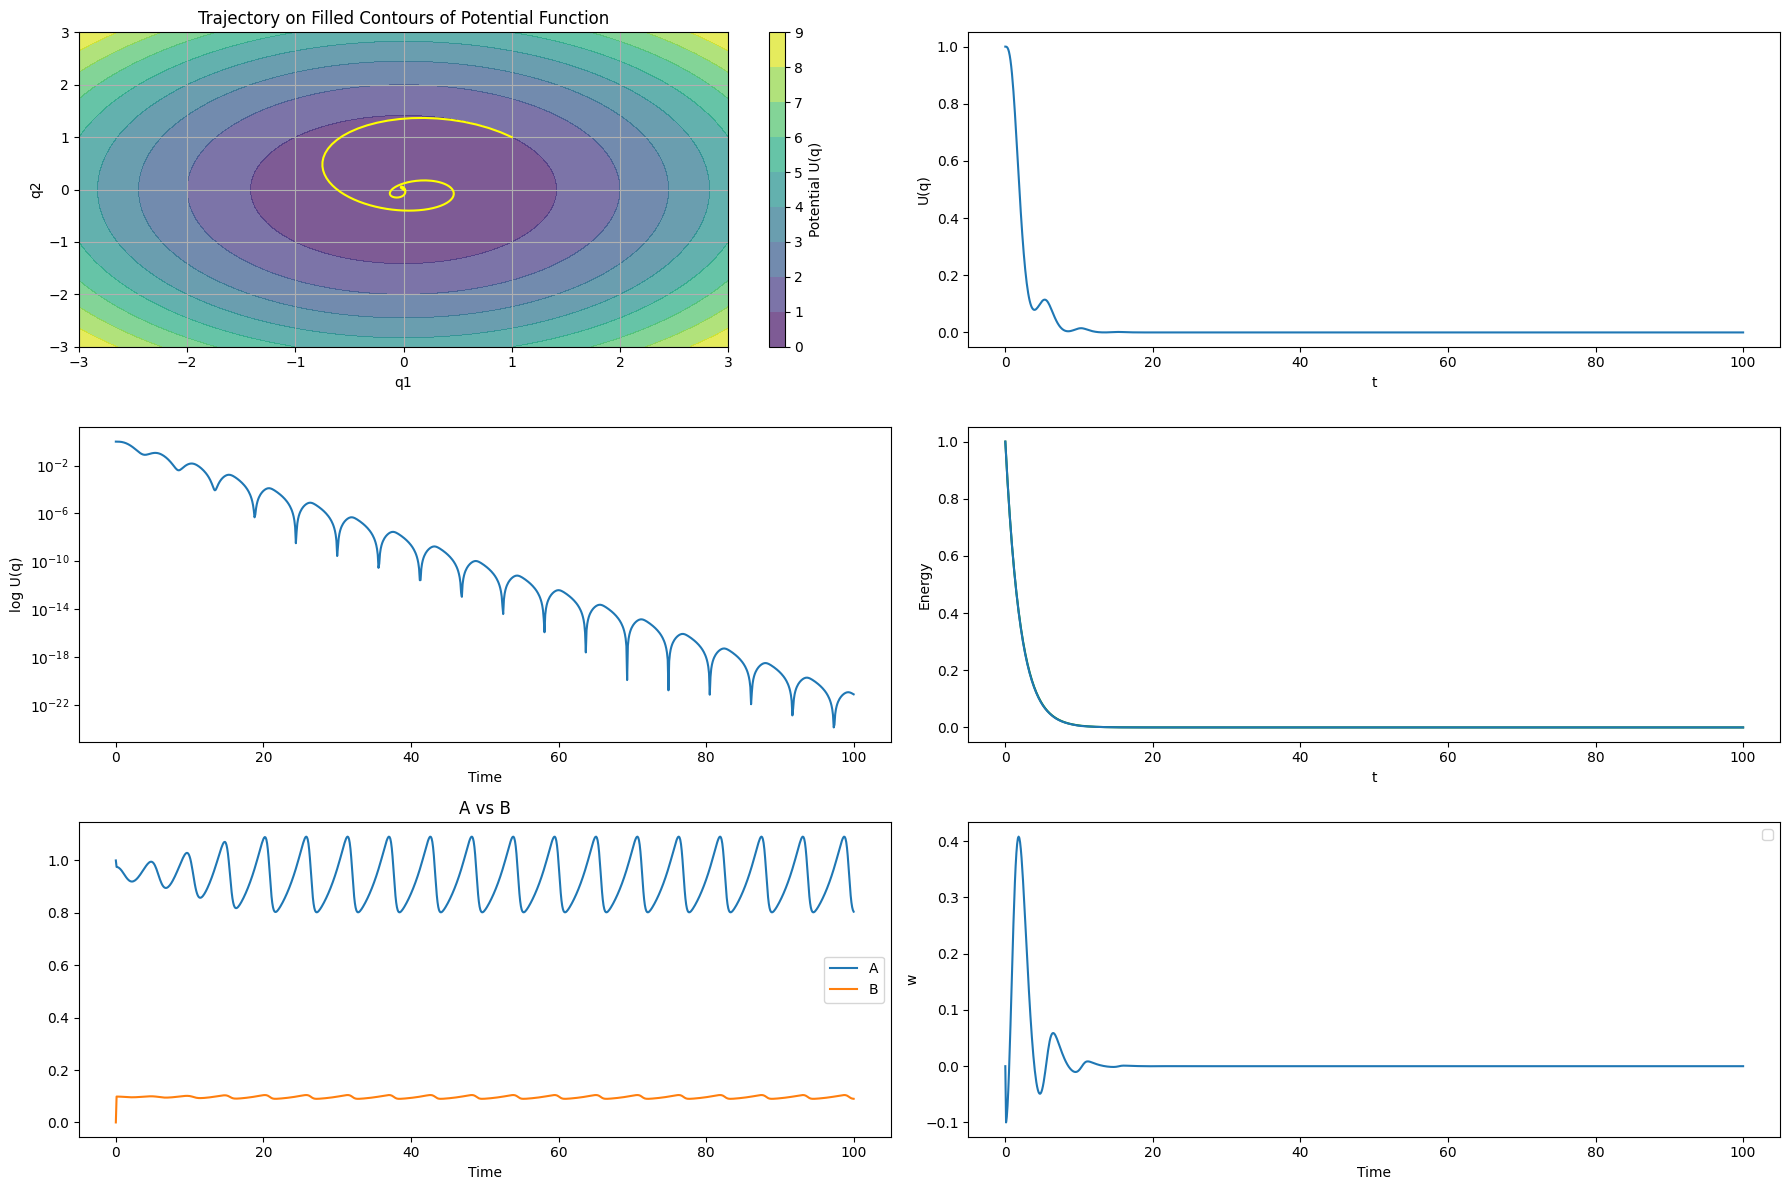

In [87]:
pars = {
    'c0': 1.,
    'gamma': 0.5,
    'ns': 1
}
Ns = 1000
h = 0.1
q0 = np.array([1., 1.])
p0 = np.array([-1., 1.])
Q = [q0]
P = [p0]
T = [0]
A = [1.]
B = [0.]
q = q0
p = p0
t = 0
U_HO = lambda x: 0.5 * (1 * x[0]**2 + 1 * x[1]**2)
Force_HO = lambda x: np.array([-1 * x[0], -x[1]])
U = [U_HO(q)]
W = [np.inner(Force_HO(q), p)]
for n in range(Ns):
    q, p, w, a, b = kd_step(q, p, t, h, pars, Force_HO)
    t += h
    Q.append(q)
    P.append(p)
    U.append(U_HO(q))
    T.append(t)
    W.append(w)
    A.append(a)
    B.append(b)
Q = np.array(Q)
P = np.array(P)
U = np.array(U)
T = np.array(T)
W = np.array(W)
A = np.array(A)
B = np.array(B)

potential_lambda = lambda X,Y: 0.5 * (1 * X**2 + 1 * Y**2)
plot_diagnostics_2D(Q,P,T,W,A,B,U,potential_lambda,pars['c0'],pars['gamma'],lim=3)

Text(0.5, 1.0, 'Error in Kinetic Energy')

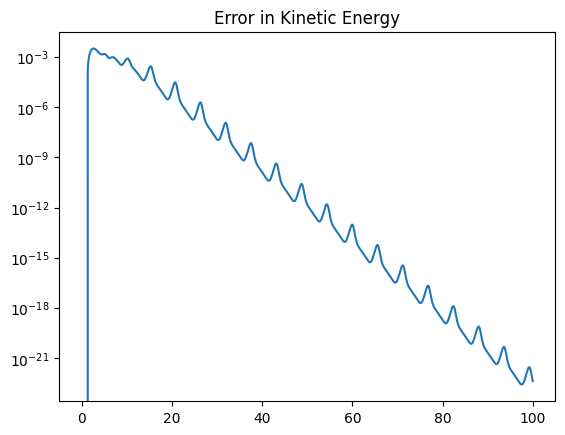

In [90]:
err = pars['c0'] * np.exp(-pars['gamma'] * T) - 0.5 * np.linalg.norm(P, axis=1)**2
plt.semilogy(T, err)
plt.title('Error in Kinetic Energy')

# Superquadratic

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


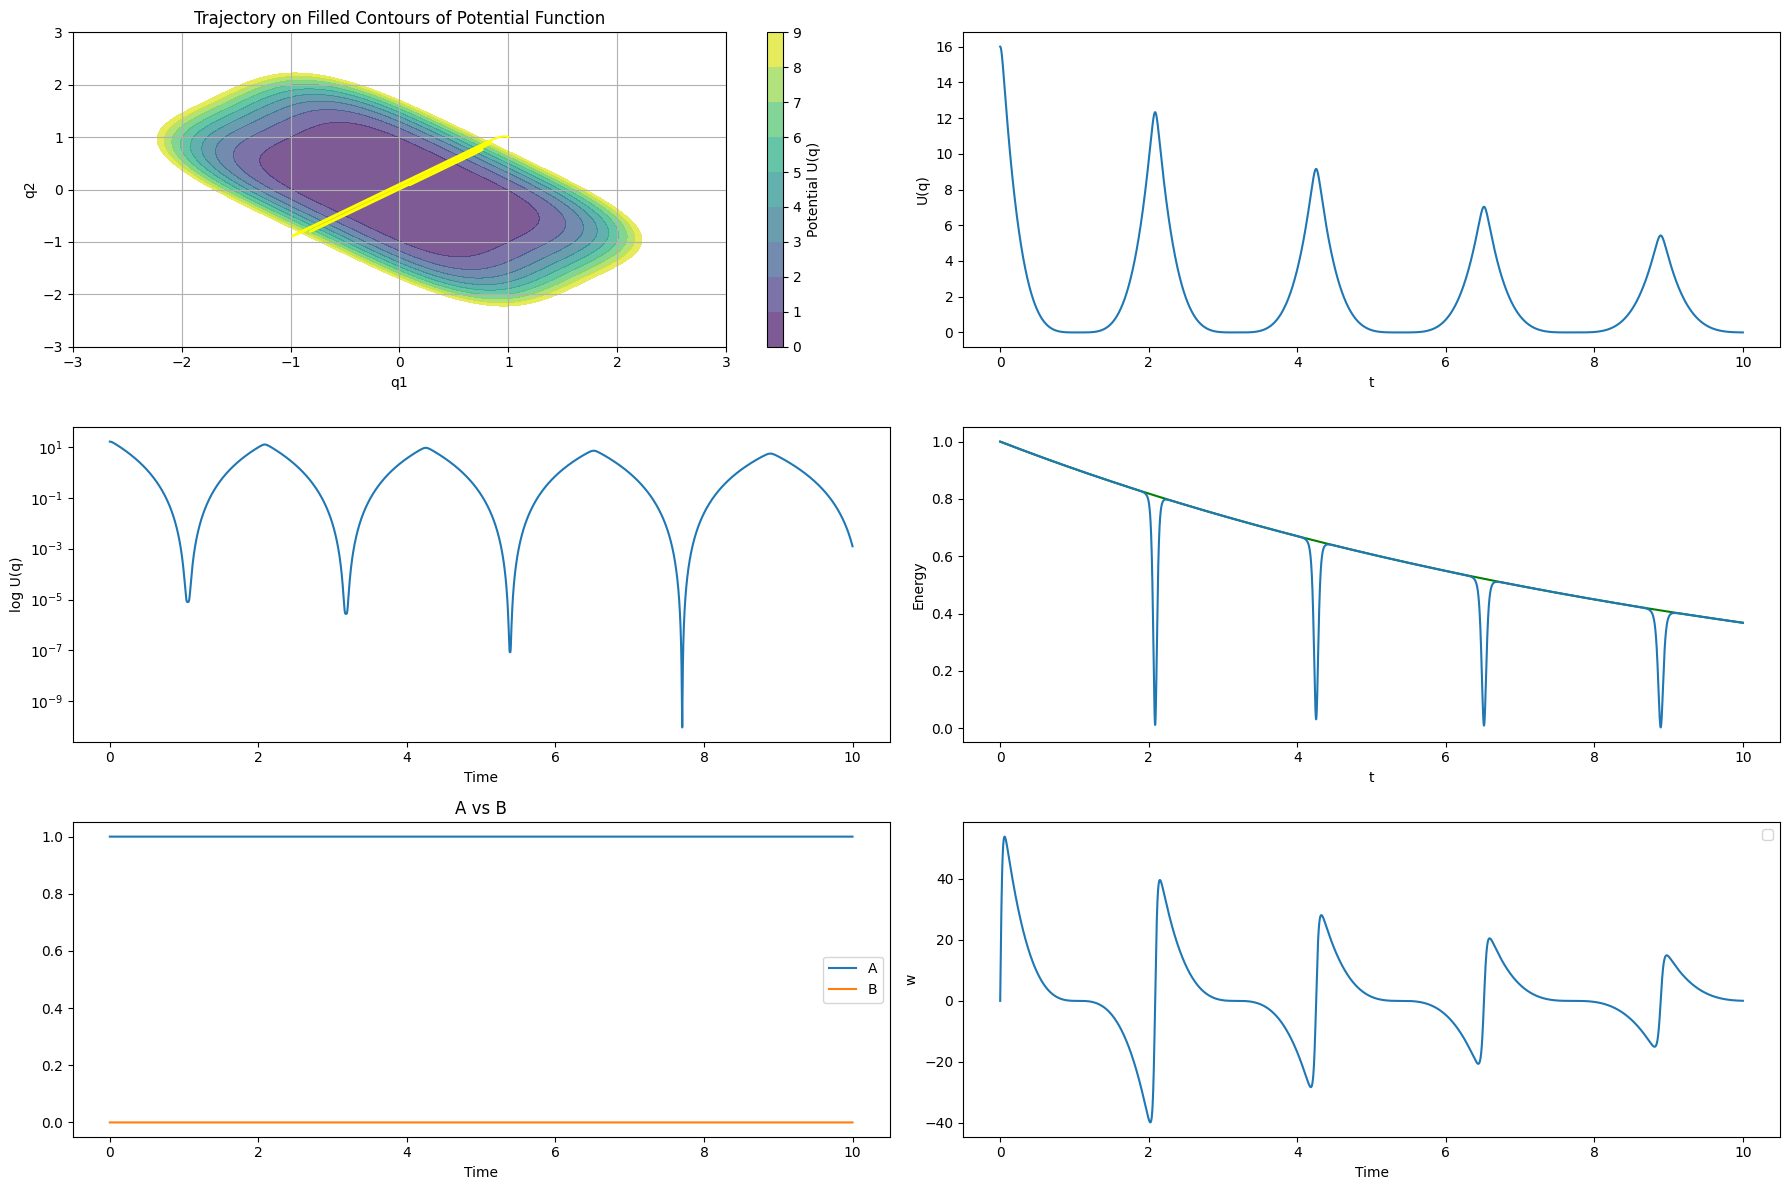

In [86]:
pars = {
    'c0': 1.,
    'gamma': 0.1,
    'ns': 1
}
Ns = 1000
h = 0.001
q0 = np.array([1., 1.])
p0 = np.array([-1., 1.])
Q = [q0]
P = [p0]
T = [0]
A = [1.]
B = [0.]
q = q0
p = p0
t = 0
U_SQ = lambda x: (x[0] + x[1])**4 + (x[0]/2 - x[1]/2)**4
Force_SQ = lambda x: np.array([
    -4 * (x[0] + x[1])**3 - 2 * (x[0]/2 - x[1]/2)**3,
    -4 * (x[0] + x[1])**3 + 2 * (x[0]/2 - x[1]/2)**3
])
U = [U_SQ(q)]
W = [np.inner(Force_SQ(q), p)]
for n in range(Ns):
    q, p, w, a, b = kd_step(q, p, t, h, pars, Force_SQ)
    t += h
    Q.append(q)
    P.append(p)
    U.append(U_SQ(q))
    T.append(t)
    W.append(w)
    A.append(a)
    B.append(b)
Q = np.array(Q)
P = np.array(P)
U = np.array(U)
T = np.array(T)
W = np.array(W)
A = np.array(A)
B = np.array(B)

potential_lambda = lambda X,Y: (X + Y)**4 + (X/2 - Y/2)**4
plot_diagnostics_2D(Q,P,T,W,A,B,U,potential_lambda,pars['c0'],pars['gamma'],lim=3)